### Ustawienie ziarna

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import hashlib
import scipy
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

seed = 0 #@param {type: "integer"}
np.random.seed(seed)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


## Funkcje celu

## Wybór parametrów

### Wybór funkcji celu

In [0]:
#@title funkcja celu { run: "auto" }

config = "rastrigin" #@param ["constant", "Gaussian function", "sum of two Gaussian functions", "rastrigin"]

### Wybór funkcji celu i parametrów (mu, sigma dla funkcji Gaussa i A dla funkcji Rastrigina)

In [0]:
A = 10 #@param {type: "integer"}
mu1 = 0 #@param {type: "integer"}
sigma1 = 1 #@param {type: "integer"}
mu2 = 0 #@param {type: "integer"}
sigma2 = 1 #@param {type: "integer"}

def constant(x):
    return 1

def gaussian(x):
    return np.sum(np.exp(-np.power(x - mu1, 2.) / (2 * np.power(sigma1, 2.))))

def two_gaussians(x):
    return gaussian(x, mu1, sigma1) + gaussian(x, mu2, sigma2)

def rastrigin(x):
    n = x.shape[0]
    return A*n + np.sum(x - A * np.cos(2 * np.pi * x))


if config == "constant":
    goal_function = constant
elif config == "rastrigin":
    goal_function = rastrigin
elif config == "sum of two Gaussian functions":
    goal_function = two_gaussians
else:
    goal_function = gaussian

### Parametry populacji

In [0]:
rozmiar_populacji = 1000 #@param {type: "integer"}
wymiar_populacji = 2 #@param {type: "integer"}

### Parametry algorytmu

In [0]:
dolna_granica = -100 #@param {type: "integer"}
gorna_granica = 100 #@param {type: "integer"}
parametr_mutacji = 1 #@param {type: "integer"}
rozmiar_turnieju = 4 #@param {type: "integer"}
p_krzyzowania = 0.5 #@param {type: "number"}
liczba_iteracji =  10#@param {type: "integer"}

# Analiza populacji

In [0]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal


class Analyzer:
    def AnalyzePopulation(self, population, iteration):
        statistics = {}
        statistics["iteration"] = iteration
        statistics["mean"] = np.mean(population, axis = 0)
        statistics["std"] = np.std(population, axis = 0)

        k, _ = optimalK(population, maxClusters=20)
        statistics["optimal_k"] = k


        kmeans = KMeans(n_clusters=k)
        kmeans.fit(population)
        
        statistics["cluster_centers"] = kmeans.cluster_centers_

        ### https://stackoverflow.com/a/50804098/4793865
        cluster_to_representants = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}

        cardinality_of_clusters = {}
        std_in_clusters = {}

        for k, v in cluster_to_representants.items():
            cardinality_of_clusters[k] = v.size
            std_in_clusters[k] = np.std(population[v], axis = 0)


        statistics["cardinality_of_clusters"] = cardinality_of_clusters
        statistics["std_in_clusters"] = std_in_clusters

        return statistics
        

## Algorytm ewolucyjny

In [0]:
class EvolutionaryAlgorithm:
    def __init__(self, goal_function, population_analyzer):
        self.LowerBound = dolna_granica
        self.UpperBound = gorna_granica

        self.populationSize = rozmiar_populacji
        self.dim = wymiar_populacji

        self.mutation_sigma = parametr_mutacji
        self.tournament_size = rozmiar_turnieju

        # change according to settings
        self.evaluate = goal_function
       
        # self.sigma = settings.sigma
        self.population = 10 * (np.random.rand(self.populationSize, self.dim) - 0.5)

        self.crossing_probability = p_krzyzowania

        self.iterations = liczba_iteracji

        self.iter = 0  # current number of iteration
        self.mutation_success_counter = 0

        self.population_analyzer = population_analyzer


    def Solve(self):
        for self.iter in range(self.iterations):
            print("iteration: ", self.iter)

            # Analyze clusters in Population            
            statistics = self.population_analyzer.AnalyzePopulation(self.population, self.iter)


            # The population is evaluated (selection). The best adapted individuals take part in the reproduction process
            self.Reproduction()

            self.Crossover()
            self.Mutate()

            self.Succession()


    def Reproduction(self):
        fitness = np.apply_along_axis(self.evaluate, 1, self.population).flatten()
        tmpPopulation = np.zeros(shape = self.population.shape)

        for i in range(self.populationSize):
            tournamentIndices = np.random.randint(self.populationSize, size = self.tournament_size)
            tmpfitness = np.zeros(shape = fitness.shape)
            tmpfitness[tournamentIndices] = fitness[tournamentIndices]
            
            tmpPopulation[i] = self.population[np.argmax(tmpfitness)]

        self.population = tmpPopulation.copy()


    def Mutate(self):
        mean_value_before = np.mean(np.apply_along_axis(self.evaluate, 1, self.population))
        self.population = self.population + self.mutation_sigma * np.random.normal(size = self.population.shape)
        mean_value_after = np.mean(np.apply_along_axis(self.evaluate, 1, self.population))

        if mean_value_after > mean_value_before:
            self.mutation_success_counter += 1

        if self.mutation_success_counter > 0.2 * self.iter:
            self.mutation_sigma *= 2.0
        else:    
            self.mutation_sigma /= 2.0





    def Crossover(self):
        number_of_crossovers = int(self.crossing_probability * self.populationSize)
            
        # In each crossover, we select two parents
        # parents are deleted from population, their child is added to population
        # this phase SHRINKS population, population will regain its original size on succession

        rows_to_delete = []
        children = np.zeros(shape = (number_of_crossovers, self.population.shape[1]))

        for i in range(number_of_crossovers):
            first_parent_ind = np.random.randint(self.populationSize)
            second_parent_ind = np.random.randint(self.populationSize)

            rows_to_delete.append(first_parent_ind)
            rows_to_delete.append(second_parent_ind)

            child = (self.population[first_parent_ind] + self.population[second_parent_ind]) / 2
            children[i] = child


        self.population = np.delete(self.population, rows_to_delete, axis = 0)
        self.population = np.append(self.population, children, axis = 0)


    def Succession(self):
        # generative succession - we are taking elements after mutation
        # we keep population size constant, that's why we are duplicatind some elements sometimes
        add_individuals = np.random.choice(self.population.shape[0], self.populationSize - self.population.shape[0])
        self.population = np.append(self.population, self.population[add_individuals], axis = 0)


## Wizualizacja populacji przed uruchomieniem algorytmu

In [0]:
analyzer = Analyzer()
alg = EvolutionaryAlgorithm(goal_function = constant, population_analyzer = analyzer)

x = []
y = []

## Uruchomienie algorytmu

In [14]:
alg.Solve()

iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9


## Wykresy

### Wizualizacja populacji po uruchomieniu algorytmu

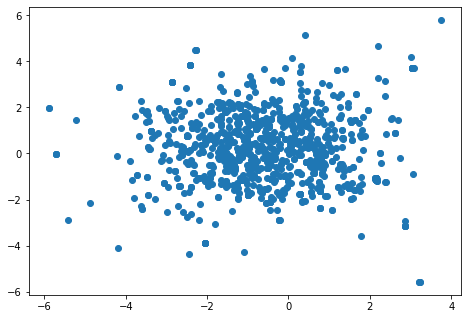

In [15]:
x2 = []
y2 = []
for obs in alg.population:
    x2.append(obs[0])
    y2.append(obs[1])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.scatter(x2, y2)